In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!eotdl version

EOTDL Version: 2025.05.26-4


# Dataset

The dataset will be composed of triplets of Sentienl 1, Sentinel 2 and Satellogic images.

We start with a public dataset of open Satellogic images, available at https://satellogic-earthview.s3.us-west-2.amazonaws.com/colab/satellogic-earthview-items.parquet

In [3]:
!curl -O https://satellogic-earthview.s3.us-west-2.amazonaws.com/colab/satellogic-earthview-items.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  258M  100  258M    0     0  11.6M      0  0:00:22  0:00:22 --:--:-- 12.7M


In [5]:
import geopandas as gpd

gdf = gpd.read_parquet('satellogic-earthview-items.parquet')

Now we can see the columns and the number of entries in the geodataframe, as we can see we have information of about 7 million images

In [6]:
gdf.info(True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7095985 entries, 0 to 7095984
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   json_path  object        
 1   zone       object        
 2   region     object        
 3   date       datetime64[ns]
 4   geometry   geometry      
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 324.8+ MB


In [7]:
gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


For each image we have a reference to the raw image and other infromation such as the date and the geometry of the image.

In [8]:
gdf.iloc[1].json_path

'data/json/zone=04N/region=603411_2346685/date=2022-09-15/20220915_010014_SN20_04N_603411_2346685_metadata.json'

The images dates are between July 1 of 2022, and December 30 of 2022. We can visualize the geographical distribution of the images in a map.

In [25]:
import folium
from folium.plugins import MarkerCluster

# sample 1000 random images
centroids = gdf.sample(1000).geometry.centroid
cluster = MarkerCluster([c.y, c.x] for c in centroids)
m = folium.Map(location=[0, 0], zoom_start=2)
cluster.add_to(m)

m

/tmp/ipykernel_2420999/1673823232.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.sample(1000).geometry.centroid


As we can see the images are distributed all over the world, although we can see that there are some areas with a higher concentration of images.

In order to retrieve an image, we first need to download the json metadata and, from it, the final link to the raw data.

In [47]:
sample = gdf.sample(1)
sample

,json_path,zone,region,date,geometry
333728,data/json/zone=11N/region=389243_3740498/date=...,11N,389243_3740498,2022-09-06,"POLYGON ((-118.1923 33.79544, -118.19235 33.79..."


In [48]:
import os

json_path = sample.iloc[0].json_path
json_dir = '/'.join(json_path.split('/')[:-1])

os.makedirs(json_dir, exist_ok=True)

!s5cmd --no-sign-request --endpoint-url https://s3.us-west-2.amazonaws.com cp 's3://satellogic-earthview/{json_path}' {json_dir}

cp s3://satellogic-earthview/data/json/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_metadata.json data/json/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_metadata.json


In [49]:
import json

metadata = json.load(open(json_path))
metadata['assets']


{'preview': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/png/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_preview.png',
  'type': 'image/png',
  'roles': ['overview']},
 'visual': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/tif/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_VISUAL.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'roles': ['data', 'visual'],
  'eo:bands': [{'name': 'Red', 'common_name': 'red'},
   {'name': 'Green', 'common_name': 'green'},
   {'name': 'Blue', 'common_name': 'blue'},
   {'name': 'NIR', 'common_name': 'nir'}]},
 'analytic': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/tif/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_TOA.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'roles': ['data', 'reflectance'

For each sample, we have different versions: 
- preview: PNG RGB version of the image
- visual: RGBNir TIFF version of the image in 8-bit precision
- analytic: RGBNir TIFF version of the image in full precision
- thumbnail: PNG thumbnail of the image

For our dataset, we will work with the analytic version of the image.

In [50]:
tif_dir = json_dir.replace('/json/', '/tif/')
tif_path = json_path.replace('/json/', '/tif/').replace('_metadata.json', '_TOA.tif')

os.makedirs(tif_dir, exist_ok=True)

!s5cmd --no-sign-request --endpoint-url https://s3.us-west-2.amazonaws.com cp 's3://satellogic-earthview/{tif_path}' {tif_dir}

cp s3://satellogic-earthview/data/tif/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_TOA.tif data/tif/zone=11N/region=389243_3740498/date=2022-09-06/20220906_183021_SN15_11N_389243_3740498_TOA.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04525..1.4935].


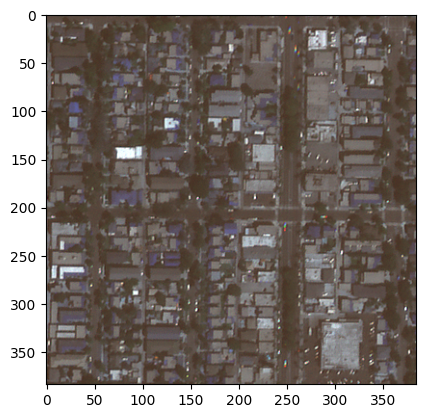

<Axes: >

In [53]:
from rasterio.plot import show
import rasterio as rio

ds = rio.open(tif_path).read((3,2,1)) / 4000

show(ds)

Finally, we can ingest the dataset into EOTDL. In this case, we will only ingest the metadata, as the full dataset would be too large.

In [54]:
os.makedirs('outputs', exist_ok=True)

!mv satellogic-earthview-items.parquet outputs/

In [56]:
# create README.md

text = """---
name: SatellogicDataset
license: https://creativecommons.org/licenses/by/4.0/
source: https://satellogic-earthview.s3.us-west-2.amazonaws.com/index.html
thumbnail: https://satellogic-earthview.s3.us-west-2.amazonaws.com/html/dataset_samples_op1.gif
authors:
  - Velázquez, Diego
  - Rodríguez, Pau
  - Alonso, Sergio
  - Gonfaus, Josep M.
  - González, Jordi
  - Richarte, Gerardo
  - Marín, Javier
  - Bengio, Yoshua
  - Lacoste, Alexandre
---

# Satellogic Dataset

The dataset includes:

- `satellogic-earthview-items.parquet`: contains the acquisition date, bounding box and path to the STAC json item file for each image.

All information is sourced from the [Satellogic Dataset](https://satellogic-earthview.s3.us-west-2.amazonaws.com/index.html) website.
"""

with open(f"outputs/README.md", "w") as outfile:
    outfile.write(text)

In [63]:
!eotdl datasets ingest -p outputs

Ingesting directory: outputs
Ingesting files: 100%|████████████████████████████| 2/2 [00:00<00:00,  3.31it/s]
No new version was created, your dataset has not changed.


In [64]:
!eotdl datasets list -n Satellogic

['SatellogicDataset']


# Finding matches

We will now add two additional columns to the datasaet with Sentinel 1 and Sentinel 2 matches.

In [3]:
import geopandas as gpd

gdf = gpd.read_parquet('outputs/satellogic-earthview-items.parquet')

gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


EOTDL offers functionality to find Sentinel 1 and Sentinel 2 matches by centroid or bounding box. In this case, we will use the centroid of the image to find the matches and specify a target size of 384x384 pixels (equal to the Satelligic image size). Due to the mismatch in resolution (1m vs 10m), the images will cover different areas. Nevertheless, a center crop of 38x38 pixels on Sentinel 1 or Sentinel 2 will match the Satellogic bounding box (we will use this in use case B for superrsolution).

In [4]:
from eotdl.access import find_sentinel_matches_by_centroid

sample = gdf.sample(1)
centroid = sample.iloc[0].geometry.centroid
date = sample.iloc[0].date

matches = find_sentinel_matches_by_centroid(
    centroid,
    date,
    time_buffer=6,
    width=384,
    height=384,
    collection_id="sentinel-2-l2a"
)

matches

[{'id': 'S2B_MSIL2A_20220801T100559_N0400_R022_T33UWV_20220801T131516',
  'properties': {'datetime': '2022-08-01T10:15:55Z', 'eo:cloud_cover': 33.27}}]

We will use a time buffer of 30 days for sentinel 2 to avoif cloud cover issues. Due to the large size of the dataset, we will proceed with a small sample. Feel free to use the entire dataset for your own experiments!

In [5]:
from tqdm import tqdm
import utils

NUM_SAMPLES = 100000
gdf_sampled = gdf.sample(NUM_SAMPLES, random_state=2025)
gdf_sampled = gdf_sampled.reset_index(drop=True)

def find_matches_parallel(gdf, time_buffer=30, width=384, height=384, collection_id="sentinel-2-l2a"):
    from concurrent.futures import ProcessPoolExecutor
    with ProcessPoolExecutor(max_workers=10) as pool:
        args = [(ix, row.geometry.centroid, row.date, time_buffer, width, height, collection_id) for ix, row in gdf.iterrows()]
        with tqdm(total=len(args)) as progress:
            futures = []
            for arg in args:
                future = pool.submit(utils._find_matches, arg) # enviamos la tupla de argumentos
                future.add_done_callback(lambda p: progress.update())
                futures.append(future)
            results = []
            for future in futures:
                result = future.result()
                results.append(result)
    return results

# results = find_matches_parallel(gdf_sampled)
# sorted_results = sorted(results, key=lambda x: x[0])
# s2_matches = [r[1] for r in sorted_results]
# gdf_sampled['s2_matches'] = s2_matches
# gdf_sampled.head()

And the same for Sentinel 1:

In [6]:
# results = find_matches_parallel(gdf_sampled, time_buffer=6, collection_id="sentinel-1-grd")
# sorted_results = sorted(results, key=lambda x: x[0])
# s1_matches = [r[1] for r in sorted_results]
# gdf_sampled['s1_matches'] = s1_matches

# gdf_sampled.head()

In [9]:
# gdf_sampled.to_parquet('outputs/satellogic-earthview-items-with-matches.parquet')

> Since the process can take a while, we recommend using the `find_matches.py` script to find the matches and save the results instead of running the code above.

We can finally save the dataset with the matches and upload to EOTDL as a new version.

In [8]:
!ls outputs/

catalog.parquet  satellogic-earthview-items.parquet
README.md	 satellogic-earthview-items-with-matches.parquet


In [ ]:
!eotdl datasets ingest -p outputs

# Download the dataset

Up until this point we have been working at the metadata level only. Once we have the list of the final images we will use, we can download the data from the original source.

In [10]:
gdf = gpd.read_parquet('outputs/satellogic-earthview-items-with-matches.parquet')

gdf.head()

,json_path,zone,region,date,geometry,s2_matches,s1_matches
0,data/json/zone=51S/region=357067_6579845/date=...,51S,357067_6579845,2022-10-26,"POLYGON ((121.50829 -30.90962, 121.50835 -30.9...",[{'id': 'S2B_MSIL2A_20221106T015619_N0400_R117...,[]
1,data/json/zone=46N/region=374867_2457086/date=...,46N,374867_2457086,2022-12-25,"POLYGON ((91.7897 22.2112, 91.78967 22.21467, ...",[{'id': 'S2A_MSIL2A_20230108T042151_N0509_R090...,[{'id': 'S1A_IW_GRDH_1SDV_20221227T234836_2022...
2,data/json/zone=38N/region=601805_4299370/date=...,38N,601805_4299370,2022-10-05,"POLYGON ((46.17736 38.83375, 46.17741 38.83721...",[{'id': 'S2A_MSIL2A_20221020T073931_N0400_R092...,[{'id': 'S1A_IW_GRDH_1SDV_20221005T030130_2022...
3,data/json/zone=20S/region=598796_7170926/date=...,20S,598796_7170926,2022-09-03,"POLYGON ((-62.01249 -25.57924, -62.01252 -25.5...",[{'id': 'S2B_MSIL2A_20220916T140709_N0400_R110...,[]
4,data/json/zone=50N/region=698978_4416263/date=...,50N,698978_4416263,2022-09-04,"POLYGON ((119.33101 39.86955, 119.33112 39.873...",[{'id': 'S2B_MSIL2A_20220918T024529_N0400_R132...,[]


For each row in the table, we will download the Satellogic image and the closest Sentinel 2 and Sentinel 1 images in time. For Sentinel 2, in addition, we will defined a maximum cloud cover threshold to avoid low quality images.

The code can be found in the `download_images.py` script.